# Project : Analyse AB Test Result

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I am working to analyse the result of A/B test run by an e-commerce website.  In this notebook I am working to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability



> ### Importing Important Libraries to work on the given data Set

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
"""Reading the dataset"""

df = pd.read_csv('F:/Github_repo/Analyze_ABTest_result/dataset-ab.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### To find the no. of rows in the Data Set using `df.shape[0]` where [0] represents rows

In [3]:
n_rows= df.shape[0]
n_rows

294478

### To find the number of unique users in the data set I am using `nunique()` function of the python and finding unique user with the help of user_id.

In [4]:
unique_users= df.user_id.nunique()
unique_users

290584

### The proportion of converted user:
> As in this data set converted users are marked by [1], so I am using only those rows which is marked as 1 in their "converted" column.
>
> Here I am using `df.query()` function to find the converted users.

In [5]:
proportion= df.query("converted == 1").shape[0]/n_rows
proportion

0.11965919355605512

### The number of times the `new_page` and `treatment` don't line up.

In [6]:
 """
 Number of rows, when group is not treatment but landing page is the new page
 """
grp_npage=df.query('group!="treatment" and landing_page=="new_page"').shape[0]

"""
 Number of rows, when group is not control but landing page is the old page
 """
grp_opage= df.query('group!="control" and landing_page=="old_page"').shape[0]

# summing both the grps

grp_sum=grp_npage+grp_opage
grp_sum


3893

### Do any of the rows/columns have missing values?

In [7]:
# Checking if there any missing value in the data set.
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

*** Above result clearly shows that this data set have no missing values***

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Creating a copy of the dataframe
df2=df

In [9]:
# dataframe where where treatment is not aligned with new_page or control is not aligned with old_page 
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
# Fine the unique user_ids 
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# There is user_id repeated in df2
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
# The row information for the repeat user_id
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# Now we remove duplicate rows
df2 = df2.drop_duplicates()

In [15]:
# Check agin if duplicated values are deleted or not
sum(df2.duplicated())

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
# Probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
# The probability of an individual converting given that an individual was in the control group
control_group = len(df2.query('group=="control" and converted==1'))/len(df2.query('group=="control"'))
control_group

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
# The probability of an individual converting given that an individual was in the treatment group
treatment_group = len(df2.query('group=="treatment" and converted==1'))/len(df2.query('group=="treatment"'))
treatment_group

0.11880724790277405

d. What is the probability that an individual received the new page?

In [19]:
# The probability of individual received new page
len(df2.query('landing_page=="new_page"'))/len(df2.index)

0.5000636646764286

### Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> - Probability of individual converting given individual is in control group = **0.1203863045004612.**
> - Probability of individual converting given individual is in treatment group = **0.11880724790277405.**
>
> This Analysis gives a strong evidence that there isn't any further conversion between new page and old page.
> Since the conversion Probability of both are nearly same, then it is neccessary to analyse other factors too.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **dataset-ab.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = len(df2.query( 'converted==1'))/len(df2.index)
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = len(df2.query('converted==1'))/len(df2.index)
p_old

0.11959667567149027

In [22]:
# probablity under null
p=np.mean([p_old,p_new])
p

0.11959667567149027

In [23]:
# difference of p_new and p_old
p_diff=p_new-p_old

#### Under null p_old is equal to p_new

c. What is $n_{new}$?

In [24]:
#calculate number of queries when landing_page is equal to new_page
n_new = len(df2.query('landing_page=="new_page"'))
#print n_new
n_new

145311

d. What is $n_{old}$?

In [25]:
#calculate number of queries when landing_page is equal to old_page
n_old = len(df2.query('landing_page=="old_page"'))
#print n_old
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
## simulate n_old transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
# simulate n_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
# differences computed in from p_new and p_old
obs_diff= new_page_converted.mean() - old_page_converted.mean()# differences computed in from p_new and p_old
obs_diff

0.00045723344638382013

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
# Create sampling distribution for difference in p_new-p_old simulated values
# with boostrapping
p_diffs = []
for i in range(10000):
    
    # 1st parameter dictates the choices you want.  In this case [1, 0]
    p_new1 = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
    p_old1 = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
    p_new2 = p_new1.mean()
    p_old2 = p_old1.mean()
    p_diffs.append(p_new2-p_old2)
#_p_diffs = np.array(_p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'Count')

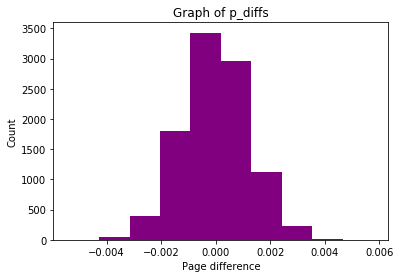

In [30]:
p_diffs=np.array(p_diffs)
#histogram of p_diff
plt.hist(p_diffs, color='purple')
plt.title('Graph of p_diffs')#title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

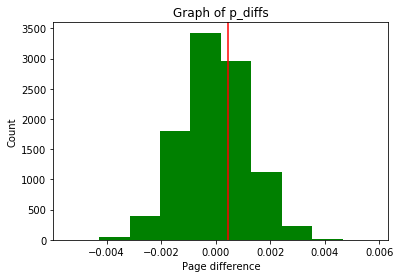

In [31]:
#histogram of p_diff
plt.hist(p_diffs, color='green');

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= obs_diff, color='r');

### What proportion of the **p_diffs** are greater than the actual difference observed in **dataset-ab.csv**?

In [32]:
var1 = df2[df2['landing_page'] == 'new_page']
var1=var1['converted'].mean()
var2 = df2[df2['landing_page'] == 'old_page']
var2 = var2['converted'].mean()
actual_diff = var1-var2
count = 0
for i in p_diffs:
    if i> actual_diff:
        count = count+1
        
print (count/(len(p_diffs)))

0.9058


### In words, explain what you just computed.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> Above calculation of p-value is almost ***90%*** of the population is above the real diffrence which suggested that, the new-page is not doing significantly better than the old page. Therefore we should stick to the null hyposthesis as p-value is very large.

### We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = len(df2.query('converted==1 and landing_page=="old_page"')) #rows converted with old_page
convert_new = len(df2.query('converted==1 and landing_page=="new_page"')) #rows converted with new_page
n_old = len(df2.query('landing_page=="old_page"')) #rows_associated with old_page
n_new = len(df2.query('landing_page=="new_page"')) #rows associated with new_page
n_new

145311

Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [34]:
#Computing z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

1.3116075339133115 0.905173705140591


### What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the finding?

In [35]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.905173705140591

In [36]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

**z_score is less than critical value of 95% confidence. Hence we fail to reject null hypothesis. Therefore the conclusion is same as part j that we accept null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
import statsmodels.api as sm
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Jun 2020   Pseudo R-squ.:               8.085e-06
Time:                        21:32:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**In Logistic regression**

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} != 0$$
**Part 2**
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Additional factors should be added into the regression models they may also influence the conversions also.**
**The disadvantage is that we don't know that our additional factor will influence the result in which direction.**
**As our additional factor changes every time on the basis of an additional factor.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
# Store Countries.csv data in dataframe
countries = pd.read_csv('dataset-countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
#Inner join two datas
new = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [42]:
#adding dummy variables with 'CA' as the baseline
new[['US', 'UK']] = pd.get_dummies(new['country'])[['US', "UK"]]
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0


In [43]:
new['US_ab_page'] = new['US']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1


In [44]:
new['UK_ab_page'] = new['UK']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1,0


In [45]:
logit3 = sm.Logit(new['converted'], new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'US_ab_page']])
logit3

In [46]:
#Check the result
result3 = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            4
Date:                Tue, 16 Jun 2020   Pseudo R-squ.:               2.590e-05
Time:                        21:32:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2388
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0366      0.028    -72.618      0.000      -2.092      -1.982
ab_page       -0.0018      0.021     -0.086      0.931      -0.043       0.039
US             0.0501      0.030      1.691      0.091      -0.008       0.108
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US_ab_page    -0.0094   2.37e+06  -3.96e-09      1.000   -4.64e+06    4.64e+06
US_ab_page    -0.0094   2.37e+06  -3.96e-09      1.000   -4.64e+06    4.64e+06
==============================================================================
"""

**Conclusions:** None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.